# Workshop Inbrain 

Google Colab Notebook: https://colab.research.google.com/drive/1TSrDeLyoRAgDJfLwToPk7p-x3n305LLY#scrollTo=TBbrAogBhZRl

Google Colab Pasta: https://drive.google.com/drive/u/0/folders/1d4u-tjEi8dCnG_PFCTj7AfkED09WVSLp


## 1. Ambiente





*   Clone Repositório

In [ ]:
!git clone https://github.com/tamiresco/inbrainlab.git

Cloning into 'inbrainlab'...
remote: Enumerating objects: 5694, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 5694 (delta 115), reused 185 (delta 78), pack-reused 5464
Receiving objects: 100% (5694/5694), 2.70 GiB | 24.09 MiB/s, done.
Resolving deltas: 100% (2101/2101), done.
Updating files: 100% (6072/6072), done.


*   Instalação das bibliotecas que o colab não tem. Se você não esta no google colab terá que instalar todas as bibliotecas usadas na cedula de importações.

In [ ]:
!pip install nilearn
!pip install Boruta
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 11.3 MB/s eta 0:00:00


*   Importação todas bibliotecas

In [ ]:
# manipulação matematica
import pandas as pd
import numpy as np

# dados neurais
from nilearn import surface, plotting, datasets

# estatistica e machine learning
from scipy import stats 
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
import shap

# graficos
import seaborn as sns
from matplotlib import pyplot as plt

## 2. Dados



*   Caminhos (onde os dados estão?)


In [ ]:
freesurfer_data_folder = "/content/inbrainlab/Data/Nki_data/"
participant = "A00008326" # nome da pasta = numero do participante

pial = "/surf/lh.pial"
area = "/surf/lh.area"
curv = "/surf/lh.curv"
sulc = "/surf/lh.sulc"
thickness = "/surf/lh.thickness"

atlasDKT = "/label/lh.aparc.DKTatlas.annot"
atlasEco = "/label/lh.Eco.annot"



*   Abrir arquivos labels e surf

In [ ]:
surface.load_surf_data(freesurfer_data_folder + participant + atlasDKT)

array([11, 11, 11, ..., 28, 28, 28], dtype=int32)

In [ ]:
surface.load_surf_data(freesurfer_data_folder + participant + thickness)

array([2.4047291, 2.637928 , 2.6400833, ..., 2.52332  , 2.505105 ,
       2.4024878], dtype=float32)

*   Vizualizar dados 

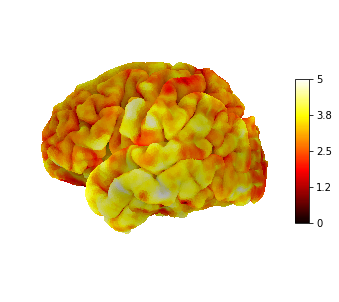

In [ ]:
plotting.plot_surf_stat_map(surf_mesh = freesurfer_data_folder + participant + pial, 
                            bg_map = freesurfer_data_folder + participant + sulc,
                            stat_map = freesurfer_data_folder + participant + thickness, 
                            
                            hemi = 'left', 
                            view = 'lateral', #'lateral','medial','dorsal','ventral'
                            bg_on_data = True,
                            colorbar = True,
                            #cmap = cmap
                            ) 
plotting.show()

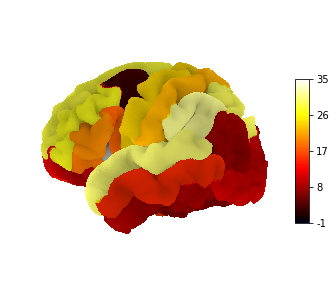

In [ ]:
plotting.plot_surf_stat_map(surf_mesh = freesurfer_data_folder + participant + pial, 
                            bg_map = freesurfer_data_folder + participant + sulc,
                            stat_map = freesurfer_data_folder + participant + atlasDKT, 
                            hemi = 'left', 
                            view = 'lateral', #'lateral','medial','dorsal','ventral'
                            bg_on_data = True,
                            colorbar = True,
                            symmetric_cbar = False,
                            #cmap = cmap
                            ) 
plotting.show()

## 3. Pre-processamento dados 

Pre-processamento é a etapa de unir os dados e criar a tabela (dataframe / database) final como foi planejada. Essa etapa também é conhecida como data engineering. Os dados que saem do freesurfer devem ser unidos e organizados da forma que faz sentido para sua analise. A principal blioteca para se fazer isso é o pandas - concatena, agrupa, pivota, soma, etc.


In [ ]:
df1 = pd.DataFrame([surface.load_surf_data(freesurfer_data_folder + participant + atlasDKT), 
                    surface.load_surf_data(freesurfer_data_folder + participant + atlasEco),
                    surface.load_surf_data(freesurfer_data_folder + participant + thickness),
                    surface.load_surf_data(freesurfer_data_folder + participant + area),
                    surface.load_surf_data(freesurfer_data_folder + participant + curv),
                    surface.load_surf_data(freesurfer_data_folder + participant + sulc)
                    ]).T
df1

,0,1,2,3,4,5
0,11.0,27.0,2.404729,0.482277,-0.068565,-4.607964
1,11.0,27.0,2.637928,0.582267,-0.071342,-4.497762
2,11.0,27.0,2.640083,0.635383,-0.099074,-4.450983
3,11.0,27.0,2.556666,0.206755,-0.128096,-4.490544
4,11.0,27.0,2.495451,0.330194,-0.153142,-4.453268
...,...,...,...,...,...,...
98994,28.0,6.0,2.264206,0.098202,-0.218100,-5.709995
98995,28.0,6.0,2.611939,0.069412,-0.168744,-6.098005
98996,28.0,6.0,2.523320,0.022037,-0.155368,-6.743779
98997,28.0,6.0,2.505105,0.196639,-0.184539,-6.143419


In [ ]:
df2 = df1.groupby(by=0).mean()
df2

,1,2,3,4,5
0,,,,,
-1.0,0.859142,0.646121,0.651157,-0.007639,0.665902
2.0,14.815554,2.602491,0.657492,-0.005933,3.215815
3.0,3.141722,2.510801,0.681740,-0.018579,1.945136
5.0,28.029476,1.883912,0.659013,-0.054132,-2.997685
6.0,20.578289,3.553457,0.677571,-0.111249,-3.754268
7.0,39.521812,2.771636,0.689374,-0.032422,1.375436
8.0,35.718765,2.618126,0.676752,-0.038180,0.806759
9.0,41.842339,3.005312,0.687276,-0.069965,-1.551551
10.0,18.155577,2.703677,0.601876,-0.008262,0.125957


 Abaixo esta uma tabela (dataframe / database) pronta. O codigo da criacao desse dataframe :


*   https://github.com/tamiresco/inbrainlab/blob/main/Notebooks/1_Thinning_Processing.ipynb
*   https://github.com/tamiresco/inbrainlab/blob/main/Scripts/freesuferdata_to_dataframe.py
*   https://github.com/tamiresco/inbrainlab/blob/main/Scripts/preprocessing.py


In [ ]:
df3 = pd.read_csv("/content/inbrainlab/Data/Economo/economo_summary_data.csv", index_col=0)
df3

,atlas_x,Hemisphere,Lobe,Thickness at 10y.o.,Thickness at 80y.o.,Curvature,Layer I thickness,Layer II thickness,Layer III thickness,Layer IV thickness,...,bigbrain_layer_5,bigbrain_layer_6,Global thinning,Global thinning normalized,structure,r2_spatial,r2_temporal,r2_complete,structure_name,atlas_y
0,10.0,0.0,5.0,2.79,2.31,0.027868,0.265759,0.209925,0.683139,0.238146,...,0.207884,0.219806,0.48,0.172043,10.0,0.732556,0.983556,0.910130,Isthmus Cingulate,10.0
1,10.0,1.0,5.0,2.71,2.32,-0.316633,0.266913,0.213113,0.686479,0.244217,...,0.206124,0.217499,0.39,0.143911,10.0,0.732556,0.983556,0.910130,Isthmus Cingulate,10.0
2,11.0,0.0,4.0,2.38,2.03,-1.789133,0.246774,0.217012,0.626959,0.232772,...,0.198371,0.204295,0.35,0.147059,11.0,-0.010000,0.610331,0.758266,Lateral Occipital,11.0
3,11.0,1.0,4.0,2.46,2.02,-1.538292,0.252469,0.222896,0.642910,0.230441,...,0.199737,0.203571,0.44,0.178862,11.0,-0.010000,0.610331,0.758266,Lateral Occipital,11.0
4,12.0,0.0,1.0,3.07,2.44,-0.786044,0.289976,0.232227,0.759549,0.189658,...,0.221332,0.241490,0.63,0.205212,12.0,0.341499,0.880375,0.932925,Lateral Orbito Frontal,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,7.0,1.0,6.0,2.99,2.39,1.413498,0.296503,0.253690,0.766168,0.252695,...,0.215642,0.213113,0.60,0.200669,7.0,0.630474,0.960891,0.955868,Fusiform,7.0
58,8.0,0.0,5.0,2.86,2.30,0.349702,0.270865,0.240233,0.734222,0.223049,...,0.209349,0.212879,0.56,0.195804,8.0,0.362650,0.858828,0.943772,Inferior Parietal,8.0
59,8.0,1.0,5.0,2.91,2.25,0.388265,0.277568,0.243510,0.740049,0.227318,...,0.209818,0.212891,0.66,0.226804,8.0,0.362650,0.858828,0.943772,Inferior Parietal,8.0
60,9.0,0.0,6.0,3.13,2.74,-1.068148,0.307015,0.271097,0.815716,0.250913,...,0.220707,0.214901,0.39,0.124601,9.0,0.579714,0.898125,0.893792,Inferior Temporal,9.0


In [ ]:
df3.columns

Index(['atlas_x', 'Hemisphere', 'Lobe', 'Thickness at 10y.o.',
       'Thickness at 80y.o.', 'Curvature', 'Layer I thickness',
       'Layer II thickness', 'Layer III thickness', 'Layer IV thickness',
       'Layer V thickness', 'Layer VI thickness', 'bigbrain_layer_1',
       'bigbrain_layer_2', 'bigbrain_layer_3', 'bigbrain_layer_4',
       'bigbrain_layer_5', 'bigbrain_layer_6', 'Global thinning',
       'Global thinning normalized', 'structure', 'r2_spatial', 'r2_temporal',
       'r2_complete', 'structure_name', 'atlas_y'],
      dtype='object')

## 4. Feature Selection

In [ ]:
# definição dos dados para regressao
target = "Global thinning"
X = df3.select_dtypes(include='number').drop(columns =[target]) 
y = df3[target]

In [ ]:
# boruta metodo
forest = RandomForestRegressor(n_jobs=-1, max_depth=20)
forest.fit(X, y)
feat_selector = BorutaPy(forest, n_estimators='auto', random_state=1, alpha= 0.001)
feat_selector.fit(X.to_numpy(), y)

# um jeito de ter guardar os resultados
feature_ranks = list(zip(X.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_,
                        ))
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Support: {}'.format(feat[0], feat[1], feat[2]))

Feature: atlas_x                   Rank: 8,  Support: False
Feature: Hemisphere                Rank: 15,  Support: False
Feature: Lobe                      Rank: 14,  Support: False
Feature: Thickness at 10y.o.       Rank: 1,  Support: True
Feature: Thickness at 80y.o.       Rank: 5,  Support: False
Feature: Curvature                 Rank: 1,  Support: True
Feature: Layer I thickness         Rank: 2,  Support: False
Feature: Layer II thickness        Rank: 5,  Support: False
Feature: Layer III thickness       Rank: 1,  Support: True
Feature: Layer IV thickness        Rank: 3,  Support: False
Feature: Layer V thickness         Rank: 2,  Support: False
Feature: Layer VI thickness        Rank: 1,  Support: True
Feature: bigbrain_layer_1          Rank: 7,  Support: False
Feature: bigbrain_layer_2          Rank: 2,  Support: False
Feature: bigbrain_layer_3          Rank: 2,  Support: False
Feature: bigbrain_layer_4          Rank: 2,  Support: False
Feature: bigbrain_layer_5          Rank: 1

In [ ]:
# T-student, ANOVA, Kruskal

#stat, p_value = stats.kruskal(g1[x],g2[x],g3[x])
#stat, p_value = stats.f_oneway(g1[x],g2[x],g3[x])
#stat, p_value = stats.ttest_ind(g1[x], g2[x])

## 5. Modelagem: treinamento, predição e avaliação

Regressor

In [ ]:
# separacao dos dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# treinamento
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

# teste de predição
y_pred = lgbm.predict(X_test)

# avaliação
r2 = r2_score(y_test, y_pred)
r2

0.6172150754648211

Classificador

In [ ]:
# definição dos dados para classificação
target = "atlas_x"
X = df3.select_dtypes(include='number').drop(columns =[target,'atlas_y']) 
y = df3[target]

In [ ]:
# separacao dos dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# treinamento
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

# teste de predição
y_pred = lgbm.predict(X_test)

# avaliação
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.5789473684210527

## 6. Explicabilidade

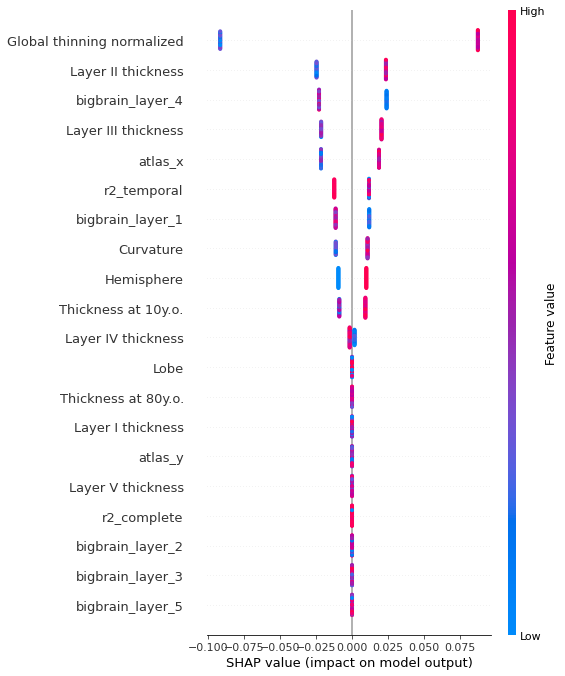

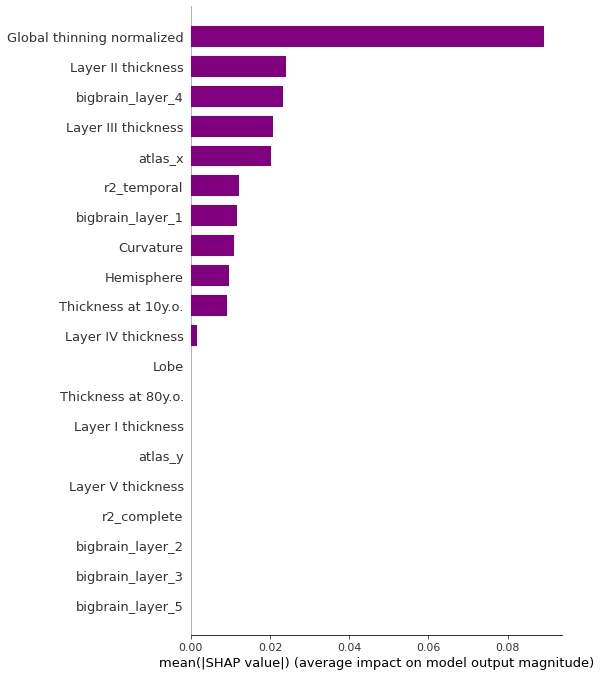

In [ ]:
# Explicação das predições do modelo lgbm
explainer = shap.Explainer(lgbm)
shap_values = explainer(X)

# Graficos
shap.summary_plot(shap_values)
shap.summary_plot(shap_values, plot_type='bar',color='purple')

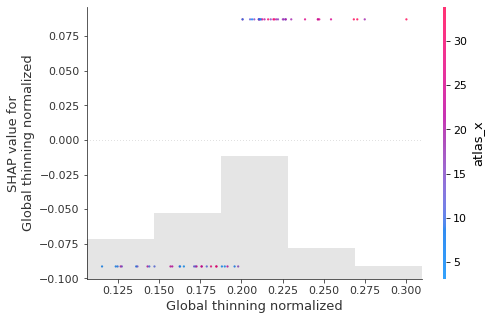

In [ ]:
shap.plots.scatter(shap_values[:, 'Global thinning normalized'], color=shap_values[:,'atlas_x'], dot_size=5, alpha =0.8)

# Exercício

Faça uma análise escolhendo alguns dos métodos anteriores e/ou variações que vocês conhecem. Fale sua hipotese e explique suas decisões matemáticas, tendo em vista as caracteristicas de cada método. Adicione ou altere pelo menos 6 linhas de código. Seja breve e simples. Por exemplo, você pode acrescentar graficos, concatenar mais dados do freesurfer ou alterar um dos algoritimos de machine learning. Deu algum problema no código ou a nivel conceitual, use https://chat.openai.com/, https://stackoverflow.com/ e https://www.google.com/. 